# Real-NVP: conceptual introduction to normalizing flows

Paper: [DENSITY ESTIMATION USING REAL NVP](https://arxiv.org/abs/1605.08803)

![Real-NVP](imgs/real-nvp-img.png)


## RealNVP Transformation

The RealNVP (Real-valued Non-Volume Preserving) is a type of normalizing flows. Each RealNVP transformation consists of a coupling layer that splits the input vector $\mathbf{x}$ into two parts and applies a transformation to one part conditioned on the other part. The transformation can be expressed as:

\begin{align*}
y_{1:d} &= x_{1:d}, \\
y_{d+1:D} &= x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d}),
\end{align*}

where:

- $\mathbf{x} \in \mathbb{R}^D$ is the input vector,
- $\mathbf{y} \in \mathbb{R}^D$ is the transformed output vector,
- $s: \mathbb{R}^d \to \mathbb{R}^{D-d}$ is a scale function,
- $t: \mathbb{R}^d \to \mathbb{R}^{D-d}$ is a translation function,
- $\odot$ denotes element-wise multiplication,
- $d$ is the dimension of the first part of the split input vector, with $D$ being the total dimension.

The first part of the input vector $x_{1:d}$ remains unchanged, while the second part $x_{d+1:D}$ undergoes an affine transformation controlled by the scale and translation functions $s$ and $t$.

The inverse transformation, which is required for sampling, can be derived as:

\begin{align*}
x_{1:d} &= y_{1:d}, \\
x_{d+1:D} &= (y_{d+1:D} - t(y_{1:d})) \odot \exp(-s(y_{1:d})).
\end{align*}

This invertibility ensures that the flow can be used both for density estimation and for generating samples from the learned distribution.

![Real-NVP](imgs/real-nvp-forward-slide.png)

## Q: let us talk about the dimensionality of the parameter space x

What is the dimensionality of the parameter space $x$? 


Possible applications:

- a generative model for images of handwritten digits
- approximate Bayesian inference of a physical model with n open parameters

## Q: how do we define scale and shift functions $s(x)$ and $t(x)$? 

### Scale and shift functions 

In [1]:
import torch
from torch import nn, Tensor
from torch.nn import functional as F


class MLP(nn.Module):
    """
    A simple multi-layer perceptron.
    """
    def __init__(self, in_dim: int, hid_dims: tuple[int, ...], out_dim: int, activation=F.leaky_relu, apply_last_act: bool = False):
        super(MLP, self).__init__()

        in_dims = [in_dim] + list(hid_dims)
        out_dims = list(hid_dims) + [out_dim]

        self.linear_layers = nn.ModuleList([
            nn.Linear(in_dim, hid_dim)
            for in_dim, hid_dim in zip(in_dims, out_dims)
        ])

        self.activation = activation
        self.apply_last_act = apply_last_act

    def forward(self, x: Tensor, context=None) -> Tensor:
        for layer in self.linear_layers[:-1]:
            x = layer(x)
            x = self.activation(x)

        x = self.linear_layers[-1](x)

        if self.apply_last_act:
            x = self.activation(x)
        return x

# Affine coupling transformation - let's write it together!

In [2]:
# Let us define some mock parameter tensor x
batch_size = 10
D: int = 10
d: int = 5 

x = torch.randn(batch_size, D)

# Define the scale and shift functions
scale = MLP(d, (16, 16), D - d)
shift = MLP(d, (16, 16), D - d)

# Split the input tensor x into two parts
x1 = x[:, :d]
x2 = x[:, d:]

# Compute the scale and shift values
s = scale(x1)
t = shift(x1)

# The first part of x remains unchanged
y1 = x1

# Apply the scale and shift to the second part of x
y2 = x2 * torch.exp(s) + t

# Concatenate the first part of x with the transformed second part
y = torch.cat([y1, y2], dim=1)

# Anything else?
# The log-determinant of the Jacobian  thise sum of the scale values
logdetjac = torch.sum(s, dim=1)


# Anything else missing?
# The inverse transformation!

## Q: do we need to compute anything else?

![training normalizing flows](imgs/nf-training-slide.png)

## $\log \left| \det \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right|$ for Real-NVP

The change of variables formula allows us to transform a simple base distribution into a more complex distribution by applying a series of invertible transformations. The change of variables formula is given by:

\begin{align*}
p_{\mathbf{x}}(\mathbf{x}) = p_{\mathbf{z}}(\mathbf{z}) \left| \det \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right|
\end{align*}

where $p_{\mathbf{z}}(\mathbf{z})$ is the probability density of the base distribution, and $\left| \det \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right|$ is the absolute value of the determinant of the Jacobian matrix of the transformation.

We use *log* probability densities for numerical reasons (efficiency, stability, simpler calculations):

\begin{align*}
\log p_{\mathbf{x}}(\mathbf{x}) = \log p_{\mathbf{z}}(\mathbf{z}) + \log \left| \det \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right|
\end{align*}



For the RealNVP transformation, the Jacobian is triangular, making the determinant calculation straightforward:

\begin{align*}
\log \left| \det \frac{\partial \mathbf{z}}{\partial \mathbf{x}} \right| = \sum_{i=1}^d s(x_{1:d})_i
\end{align*}


## Q: why exponent in the scale function?

### General interface of transform modules (unconditional)

In [3]:
from torch import Tensor


class UnconditionalTransform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Forward pass of the transform.
        :param x: The input tensor.
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        raise NotImplementedError()

    def inverse(self, y: Tensor) -> tuple[Tensor, Tensor]:
        """
        Inverse pass of the transform.
        :param y: The input tensor.
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        raise NotImplementedError()

### Real NVP layer

In [4]:
class AffineCouplingTransform(UnconditionalTransform):
    """
    An affine coupling transform for Real-NVP.
    """
    def __init__(self, mask: Tensor, hidden_features: int = 16, num_layers: int = 2):
        """
        Initialize the affine coupling layer.

        :param mask: A boolean tensor that indicates which parameters are transformed by the affine coupling layer.
            True means that the parameter is passed through unchanged (x_{1:d}), False means that it is transformed (x_{d+1:D}).
        :param hidden_features: The number of hidden features in the scale and shift MLP networks. 
        :param num_layers: The number of layers in the scale and shift MLP networks. 
        """
        super().__init__()

        # The mask used to split the input tensor into two parts
        self.mask = mask

        # The number of parameters that will stay unchanged (d in the paper notation)
        num_unchanged_params: int = mask.sum().item()

        # The number of parameters that will be transformed (D - d in the paper notation)
        num_transformed_params: int = mask.size(0) - num_unchanged_params

        # Define the scale network (MLP) with the given hidden features and number of layers
        self.scale = MLP(num_unchanged_params, [hidden_features] * num_layers, num_transformed_params)

        # Define the shift network (MLP) with the same structure as the scale network
        self.shift = MLP(num_unchanged_params, [hidden_features] * num_layers, num_transformed_params)


    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the affine coupling layer.
        :param x: Input tensor of shape (batch_size, num_features).
        :return: Transformed tensor and the log-determinant of the Jacobian.
        """
        # Split the input tensor x into two parts, x_a (x_{1:d}) and x_b (x_{d+1:D})
        x_a, x_b = x[:, self.mask], x[:, ~self.mask]

        # Calculate the scale and shift terms from x_a
        log_scale = self.scale(x_a)
        shift = self.shift(x_a)

        # The first part of x remains unchanged
        y_a = x_a

        # Apply the affine transformation to x_b
        y_b = x_b * torch.exp(log_scale) + shift

        # Calculate the log-determinant of the Jacobian
        logdetjac = log_scale.sum(dim=1)

        # Concatenate y_a and inverse transformed x_b to get the original input tensor
        # Respecting the order in the mask
        y = torch.empty_like(x)
        y[:, self.mask] = y_a
        y[:, ~self.mask] = y_b

        # Return the output tensor and the log-determinant of the Jacobian
        return y, logdetjac


    def inverse(self, y: Tensor) -> Tensor:
        """
        Inverse pass of the affine coupling layer.
        :param y: Transformed tensor of shape (batch_size, num_features).
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        # Split the transformed tensor y into two parts, y_a (y_{1:d}) and y_b (y_{d+1:D})
        y_a, y_b = y[:, self.mask], y[:, ~self.mask]

        # Calculate the scale and shift terms from y_a
        log_scale = self.scale(y_a)
        shift = self.shift(y_a)

        # The first part of y remains unchanged
        x_a = y_a

        # Apply the inverse affine transformation to y_b to get x_b
        x_b = (y_b - shift) * torch.exp(-log_scale)

        # Calculate the log-determinant of the Jacobian
        logdetjac = -log_scale.sum(dim=1)

        # Concatenate y_a and inverse transformed x_b to get the original input tensor
        # Respecting the order in the mask
        x = torch.empty_like(y)
        x[:, self.mask] = x_a
        x[:, ~self.mask] = x_b

        # Return the original input tensor and the log-determinant of the Jacobian
        return x, logdetjac

# Q: how can we test that the transform is implemented correctly?

In [5]:
batch_size = 10
D: int = 10
d: int = 5

# Define the mask for the affine coupling layer
mask = torch.zeros(D, dtype=torch.bool)
mask[:d] = True

# Define the input tensor x
x = torch.randn(batch_size, D)

# Create an instance of the affine coupling layer
affine_coupling = AffineCouplingTransform(mask)

# Forward pass of the affine coupling layer
y, logdetjac = affine_coupling(x)

# Inverse pass of the affine coupling layer
x_inv, logdetjac_inv = affine_coupling.inverse(y)

# Check if the inverse transformation is correct
assert torch.allclose(x, x_inv), "The inverse transformation is not correct."

# Check if the log-determinant of the Jacobian is correct
assert torch.allclose(logdetjac, -logdetjac_inv), "The log-determinant of the Jacobian is not correct."

## Combine transformations

In [6]:
class CompositeTransform(UnconditionalTransform):
    """
    A composition of transformations.
    """
    def __init__(self, transforms: list[UnconditionalTransform]):
        super().__init__()

        # Create a list of affine coupling layers
        self.transforms = nn.ModuleList(list(transforms))

    def forward(self, x: Tensor) -> tuple[Tensor, Tensor]:
        """
        Forward pass of the sequence of affine coupling layers.
        :param x: Input tensor of shape (batch_size, num_features
        :return: Transformed tensor and the log-determinant of the Jacobian.
        """
        logdetjac = torch.zeros(x.size(0), device=x.device)

        # Apply each affine coupling layer in the sequence
        for transform in self.transforms:
            x, ldj = transform(x)
            logdetjac += ldj

        return x, logdetjac
    
    def inverse(self, y: Tensor) -> tuple[Tensor, Tensor]:
        """
        Inverse pass of the sequence of affine coupling layers.
        :param y: Transformed tensor of shape (batch_size, num_features).
        :return: A tuple of the output tensor and the log-determinant of the Jacobian.
        """
        logdetjac = torch.zeros(y.size(0), device=y.device)

        # Apply each affine coupling layer in the sequence in reverse order
        for transform in reversed(self.transforms):
            y, ldj = transform.inverse(y)
            logdetjac += ldj

        return y, logdetjac

## Data (synthetic "moons" dataset)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def sample_moons(n_samples: int, noise: float = 0.1) -> Tensor:
    """
    Sample a moons dataset using scikit-learn.
    :param n_samples: The number of samples to generate.
    :param noise: The standard deviation of the Gaussian noise added to the data.
    :return: A tensor of shape (n_samples, 2) containing the samples.
    """
    from sklearn.datasets import make_moons

    # draw samples from the training distribution
    moon_samples, _ = make_moons(n_samples=n_samples, noise=noise)

    # Convert the data to a PyTorch tensor
    return torch.tensor(moon_samples, dtype=torch.float32)

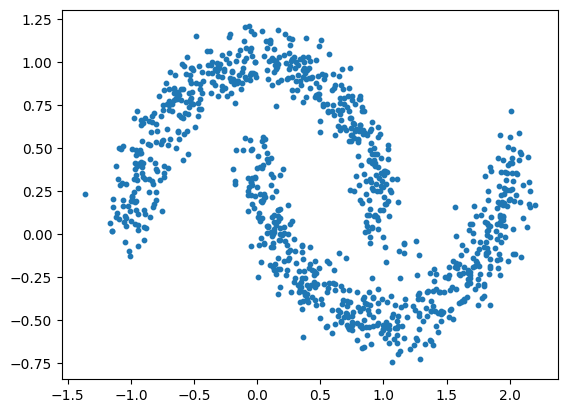

In [9]:
samples = sample_moons(1000)

plt.scatter(samples[:, 0], samples[:, 1], s=10)

# Define transforms

In [15]:
# Build a simple Real-NVP model with several affine coupling layers

transforms = []
D = 2
num_transforms = 5
hidden_features = 64
num_mlp_layers = 3

for i in range(num_transforms):
    # Create a mask for the affine coupling layer
    mask = torch.arange(D) % 2 == i % 2
    print(mask)

    # Create an affine coupling layer with 16 hidden features and 2 layers
    transform = AffineCouplingTransform(mask, hidden_features, num_layers=num_mlp_layers)

    # Add the affine coupling layer to the list of transforms
    transforms.append(transform)


# Create a sequence of affine coupling layers
transforms = CompositeTransform(transforms)


tensor([ True, False])
tensor([False,  True])
tensor([ True, False])
tensor([False,  True])
tensor([ True, False])


# Q: what are the two operations that normalizing flows (density estimator) provide? 

## Define Flows object

In [11]:
class RealNVPFlows(nn.Module):
    def __init__(self, transform: UnconditionalTransform, base_dist):
        super().__init__()
        self.transform = transform
        self.base_dist = base_dist

    def sample(self, num_samples: int) -> Tensor:
        """
        Sample from the RealNVP model.
        :param num_samples: The number of samples to generate.
        :return: A tensor of shape (num_samples, num_features) containing the samples.
        """
        samples = self.base_dist.sample((num_samples, ))
        return self.transform.inverse(samples)[0]

    def log_prob(self, samples: Tensor) -> Tensor:
        """
        Evaluate the log-probability density of the RealNVP model.
        :param samples: A tensor of shape (batch_size, num_features) containing the samples.
        :return: A tensor of shape (batch_size,) containing the log-probability densities.
        """
        z, logdetjac = self.transform(samples)
        return self.base_dist.log_prob(z).sum(-1) + logdetjac


    def to(self, device):
        super().to(device)
        self.transform.to(device)

        # some dirty workaround - torch distributions are not nn.Module subclasses

        for k, t in list(base_dist.__dict__.items()):
            if isinstance(t, Tensor):
                setattr(base_dist, k, t.to(device))
        return self

In [16]:
from torch.distributions import Normal

base_dist = Normal(torch.zeros(D), torch.ones(D))

flow = RealNVPFlows(transforms, base_dist)

print('Number of parameters: ', sum(p.numel() for p in flow.parameters()))

Number of parameters:  85130


# Train the model

In [13]:
from tqdm.notebook import tqdm, trange
from torch.optim import Adam

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

flow.to(device)

optim = Adam(flow.parameters(), lr=1e-3)

flow.train();

In [18]:
# training loop

num_epochs = 500
batch_size = 256
losses = []

pbar = trange(num_epochs)

for epoch in pbar:
    optim.zero_grad()

    samples = sample_moons(batch_size).to(device)
    log_prob = flow.log_prob(samples)

    # log_prob = flow.log_prob(samples)
    loss = -log_prob.mean()

    loss.backward()
    optim.step()

    losses.append(loss.item())

    pbar.set_description(f"Loss: {loss.item():.2e}")


  0%|          | 0/500 [00:00<?, ?it/s]

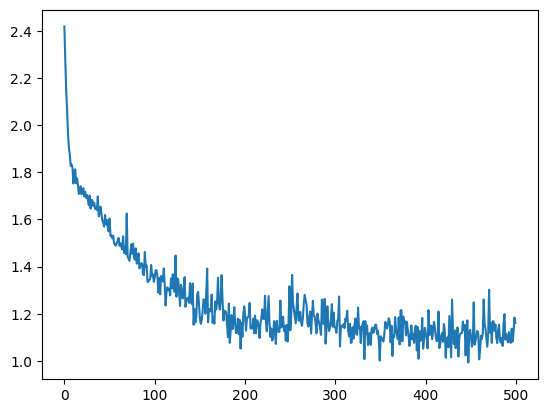

In [19]:
plt.plot(losses)

# Visualizations

In [20]:
def plot_density_on_grid(flow):
    """
    Evaluate the density of the flow model on a 2D grid and plot it.
    """
    fig, ax = plt.subplots(1, 1)
    xline = torch.linspace(-1.5, 2.5, 100)
    yline = torch.linspace(-.75, 1.25, 100)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    flow.eval()

    with torch.no_grad():
        zgrid = flow.log_prob(xyinput.to(device)).cpu().exp().reshape(100, 100)

    ax.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
    plt.show()


C:\Users\49162\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


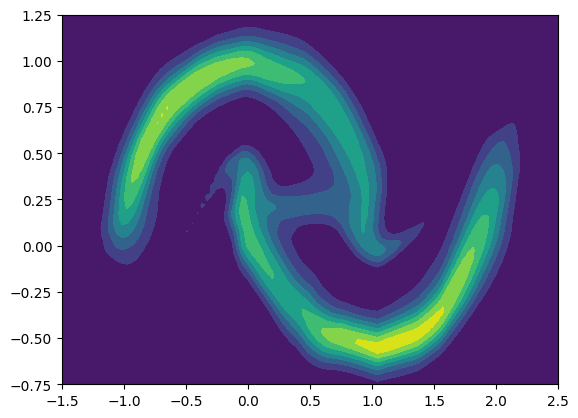

In [21]:
plot_density_on_grid(flow)

(-0.75, 1.25)

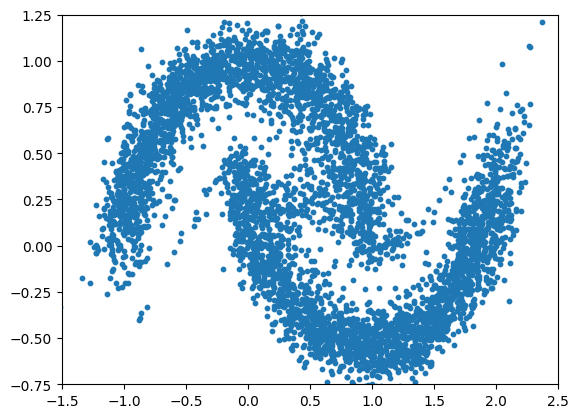

In [22]:
# sample

flow.eval()

with torch.no_grad():
    samples = flow.sample(5000)

plt.scatter(samples[:, 0].cpu().numpy(), samples[:, 1].cpu().numpy(), s=10)
plt.xlim([-1.5, 2.5])
plt.ylim([-0.75, 1.25])

In [23]:
import seaborn as sns

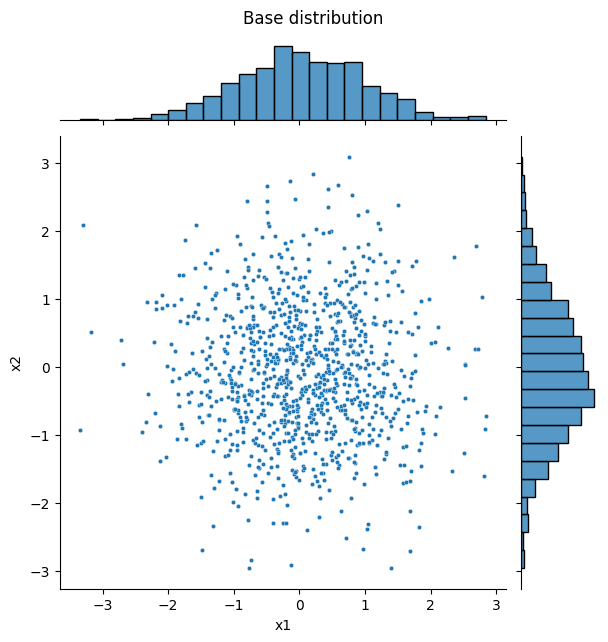

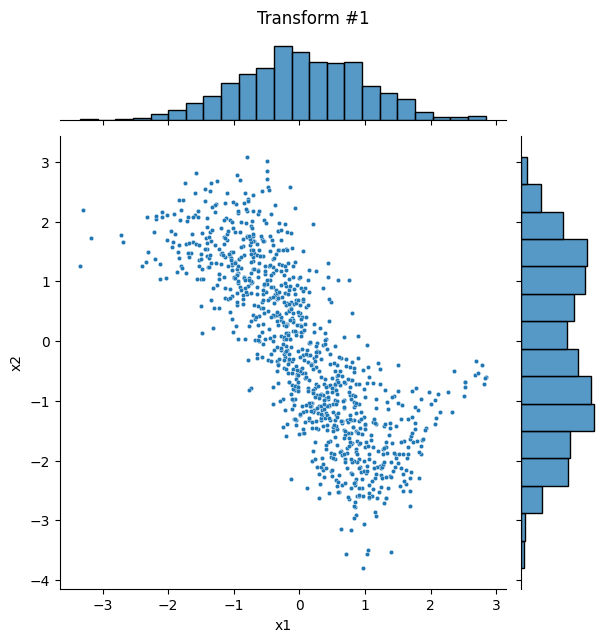

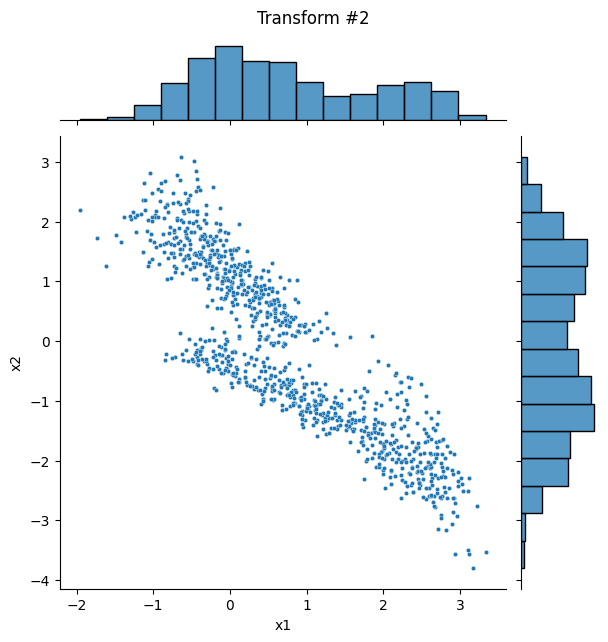

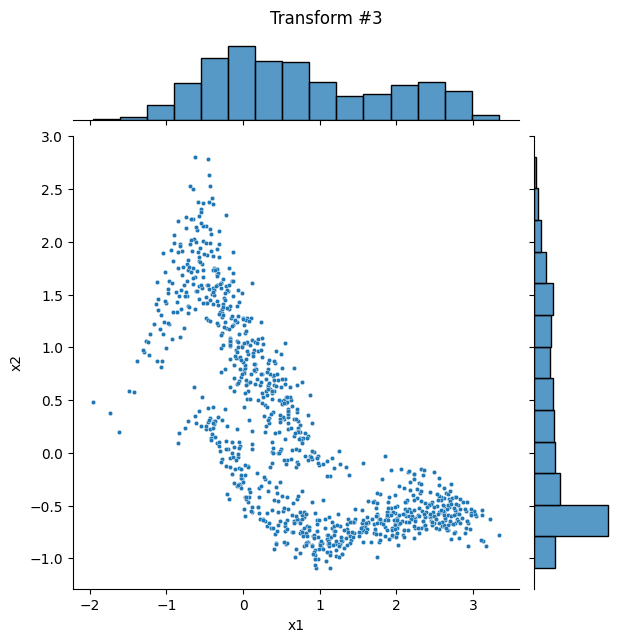

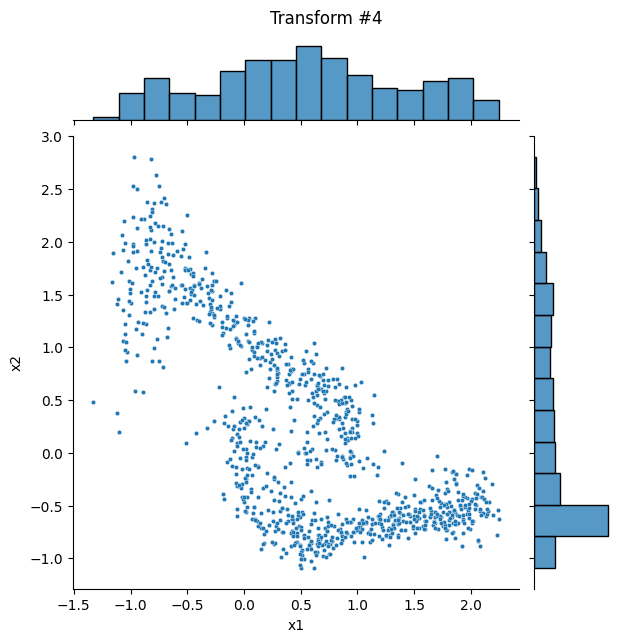

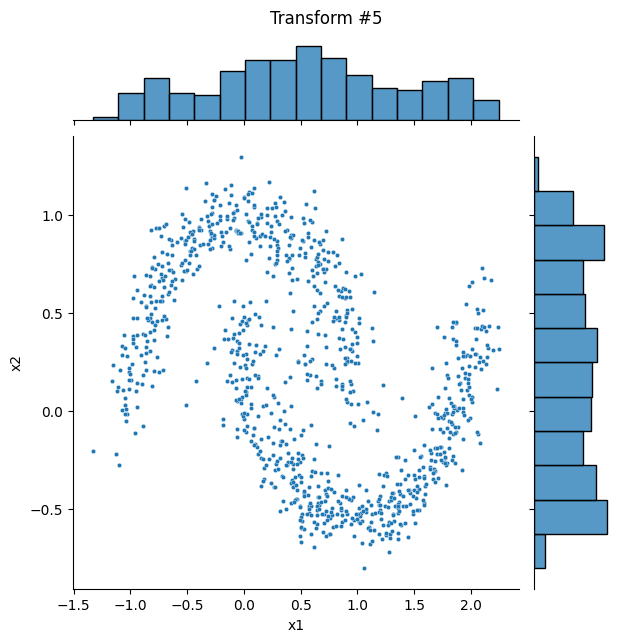

In [24]:
# sample


def plot_samples(samples, title=None):

    joint_plot = sns.jointplot(x=samples[:, 0].cpu().numpy(), y=samples[:, 1].cpu().numpy(), s=10)
    joint_plot.set_axis_labels('x1', 'x2')
    
    if title:
        plt.suptitle(title, y=1.03)

    plt.show()

flow.eval()

with torch.no_grad():
    base_samples = flow.base_dist.sample((1000, ))
    plot_samples(base_samples, 'Base distribution')

    x = base_samples
    for i, transform in enumerate(reversed(flow.transform.transforms)):
        x, _ = transform.inverse(x)
        plot_samples(x, f'Transform #{i + 1}')

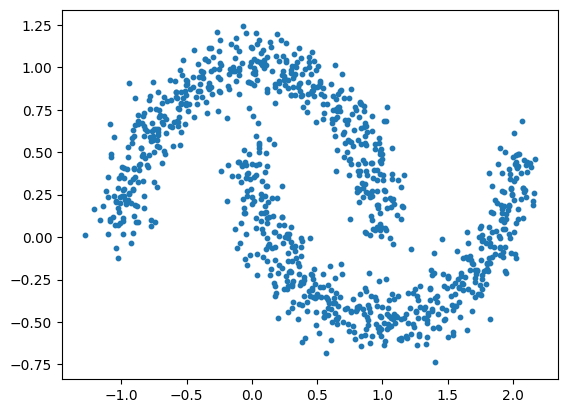

In [25]:
# data (again)

samples = sample_moons(1000)

plt.scatter(samples[:, 0], samples[:, 1], s=10)

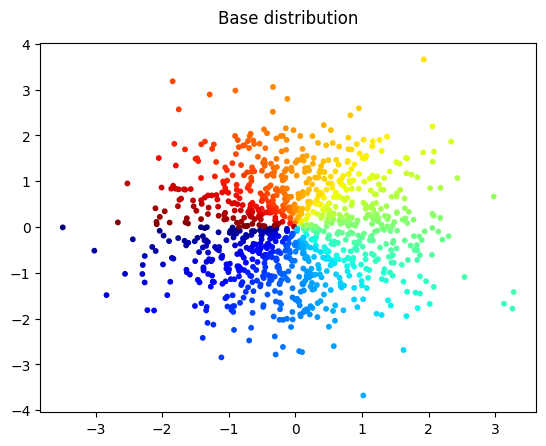

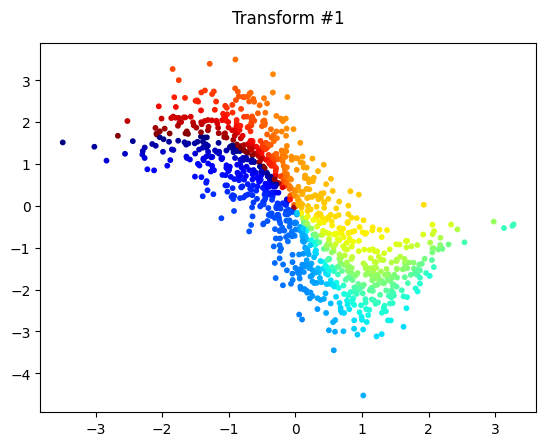

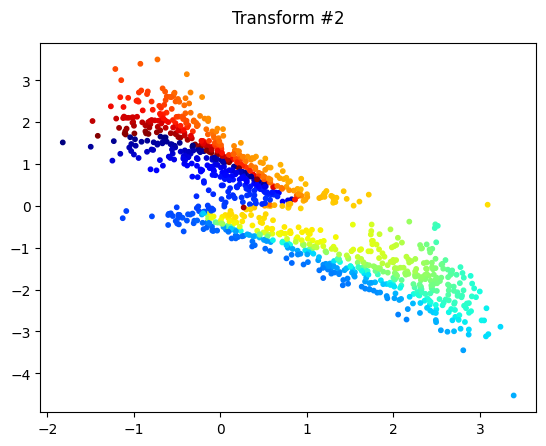

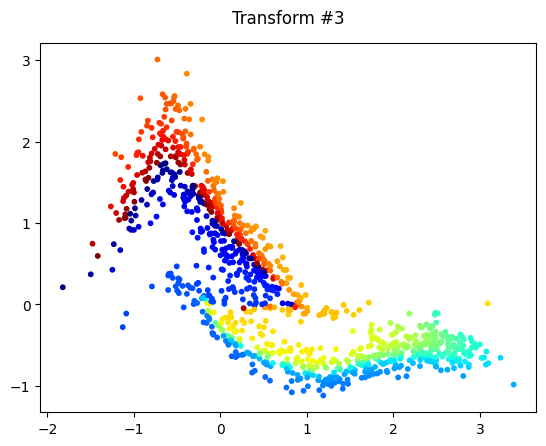

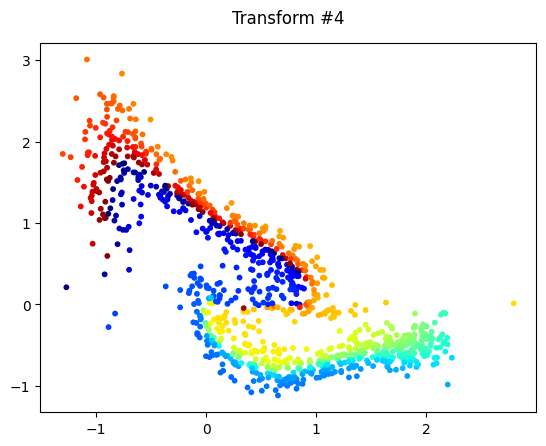

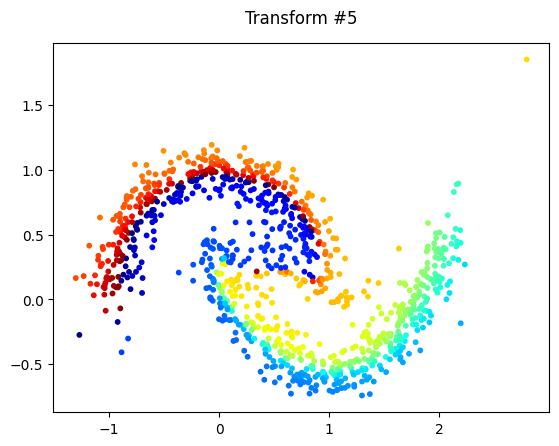

In [39]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_samples(samples, colors, title=None):
    """
    Plot samples with colors based on their polar angle.
    :param samples: Tensor of shape (num_samples, 2)
    :param colors: Numpy array of colors.
    :param title: Optional title for the plot.
    """
    # Plot using seaborn jointplot

    plt.scatter(samples[:, 0].cpu().numpy(), samples[:, 1].cpu().numpy(), s=10, c=colors)
    
    if title:
        plt.title(title, y=1.03)

    plt.show()

# Ensure the flow is in evaluation mode
flow.eval()

with torch.no_grad():
    # Sample from the base distribution
    base_samples = flow.base_dist.sample((1000, ))

    # Compute the polar angles and assign colors
    polar_angles = torch.atan2(base_samples[:, 1], base_samples[:, 0]).cpu().numpy()
    colors = plt.get_cmap('jet')((polar_angles + np.pi) / (2 * np.pi))  # Normalize angles to [0, 1] for coloring

    # Plot the base samples with colors
    plot_samples(base_samples, colors, 'Base distribution')

    # Transform the samples and plot each step while maintaining colors
    x = base_samples
    for i, transform in enumerate(reversed(flow.transform.transforms)):
        x, _ = transform.inverse(x)
        plot_samples(x, colors, f'Transform #{i + 1}')